# Ultrasound breast imaging with Forge

In this notebook we solve the inverse problem, using full-waveform inversion to reconstruct an acoustic velocity model.

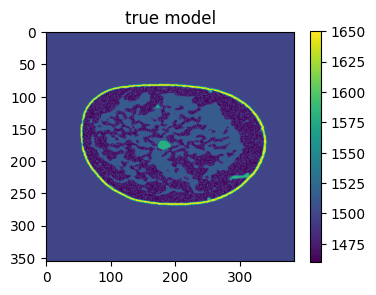

In [1]:
import numpy as np

# Load the 2D anastasio breast model and set a water starting model
m = np.load('./data/anastasio2D.npy')
m0 = np.empty_like(m)
m0[:,:] = 1500
dx = 5e-4

import matplotlib.pyplot as plt

# Plot the true model
plt.figure(figsize=(4,3))
plt.imshow(m)
plt.title('true model')
plt.colorbar()
plt.show()

In [2]:
# Load the transducer geometry
r_geometry = np.load('./data/geometry.npy')
s_geometry = r_geometry.copy()

In [3]:
# Set the source frequency and minimum number of grid-points per wavelength
frequency = 5e5
gridpoints_per_wavelength = 5

# Calculate new grid spacing required to ensure the minimum number of grid-points per wavelength
min_wavelength = m.min()/frequency
dxi = min_wavelength/gridpoints_per_wavelength

In [4]:
# Convert geometry coordinates from meters to grid-cells
r_posi = r_geometry/dxi
s_posi = s_geometry/dxi

In [5]:
from forge.utils import resample

# Interpolate models to required grid-spacing dxi
mi = resample(m, dx, dxi)
m0i = resample(m0, dx, dxi)

In [6]:
# Set the temporal increment, dt, to be small enough to meet the CFL condition for numerical stability
courant = 0.6
dt = (courant*dxi)/mi.max()

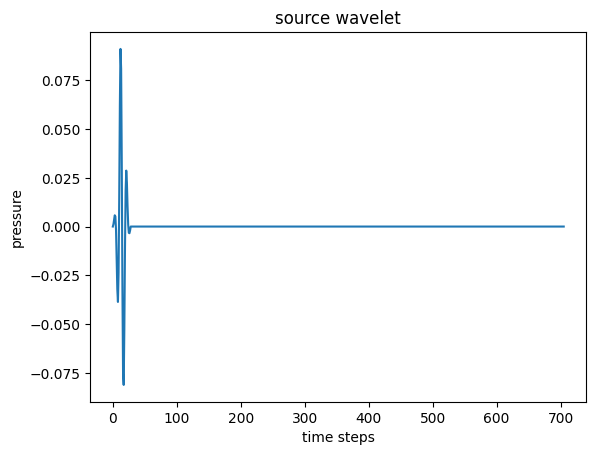

In [7]:
from forge.utils import tone_burst

time = 0.00015  # Maximum time in seconds
amplitude = 1e-1  #  Maximum source pressure 
num = round(time/dt) #  Number of time-steps
num_cycles = 3  # Use a 3 cycle tone-burst

# Define the source wavelet 
source = tone_burst(dt, frequency, num_cycles, num, amplitude, plot=True)

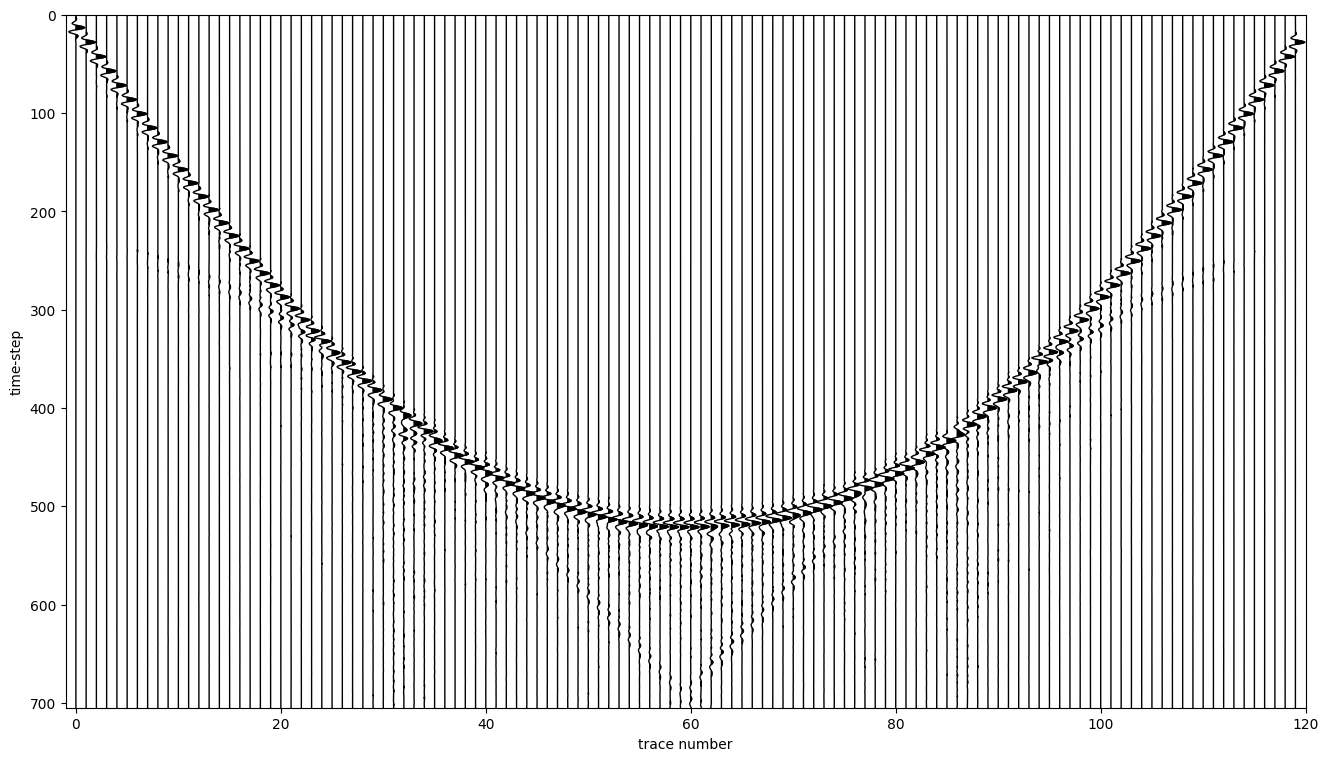

In [8]:
import torch

# Load the forward modelled data
d = torch.from_numpy(np.load('./data/d.npy'))

from forge.utils import trace_plot, normalize

# Visualize traces of true modelled data
trace_plot(normalize(d), 0, scale_fac=1.8, size=(16, 9))

In [9]:
from forge.model import FullWaveformInversion

# Instantiate a FullWaveformInversion class for the inversion
model = FullWaveformInversion(model = m0i,  # Starting model
                              dx = dxi,  # Spatial increment
                              dt = dt,  # Temporal increment
                              r_pos = r_posi,  # Receiver positions
                              sampling_rate = 7)

device = cuda:0


In [10]:
# Define a stochastic gradient descent optimizer with momentum
opt = torch.optim.SGD([model.m], lr=1e-5, momentum=0.4)

# Define a shot-normalized L2 loss function 
def l2_loss(input, target):
    return torch.norm(normalize(input, type='shot') - normalize(target, type='shot'))**2

In [11]:
# Invert the data with .fit()
model.fit(data = d,  # True data
          s_pos = s_posi,  # Source locations in grid-cells
          source = source,  # Source wavelet
          optimizer = opt,  # Optimizer
          loss = l2_loss,  # Loss function
          num_iter = 6,  # Number of iterations per frequency block
          bs = 20,  # Batch size/number of sources per forward run
          blocks = [3e5, 4e5, 5e5],  # Multi-scale frequency blocks
          box = (mi.min(), mi.max()),  # Box constraints
          true_model = mi)  # True model for reporting inversion RMSE

2024-04-26 14:51:49  block 1/3    3e+05Hz
2024-04-26 14:51:49    iteration 1/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 271.36it/s]


2024-04-26 14:51:56      loss = 1.11e-07
2024-04-26 14:51:56      rmse = 0.0001947
2024-04-26 14:51:56    iteration 2/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 269.67it/s]


2024-04-26 14:52:03      loss = 8.462e-08
2024-04-26 14:52:03      rmse = 0.0001757
2024-04-26 14:52:03    iteration 3/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 272.90it/s]


2024-04-26 14:52:10      loss = 1.596e-07
2024-04-26 14:52:10      rmse = 0.0001654
2024-04-26 14:52:10    iteration 4/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 271.71it/s]


2024-04-26 14:52:16      loss = 1.425e-07
2024-04-26 14:52:16      rmse = 0.0001527
2024-04-26 14:52:16    iteration 5/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 277.17it/s]


2024-04-26 14:52:21      loss = 7.907e-08
2024-04-26 14:52:21      rmse = 0.0001461
2024-04-26 14:52:21    iteration 6/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 267.87it/s]


2024-04-26 14:52:27      loss = 6.727e-08
2024-04-26 14:52:27      rmse = 0.000142
_______________________________________________________ 

2024-04-26 14:52:27  block 2/3    4e+05Hz
2024-04-26 14:52:27    iteration 1/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 279.36it/s]


2024-04-26 14:52:36      loss = 5.372e-07
2024-04-26 14:52:36      rmse = 0.0001359
2024-04-26 14:52:36    iteration 2/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 277.47it/s]


2024-04-26 14:52:42      loss = 3.19e-07
2024-04-26 14:52:42      rmse = 0.0001347
2024-04-26 14:52:42    iteration 3/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 277.13it/s]


2024-04-26 14:52:49      loss = 1.867e-07
2024-04-26 14:52:49      rmse = 0.0001288
2024-04-26 14:52:49    iteration 4/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 279.99it/s]


2024-04-26 14:52:54      loss = 3.099e-08
2024-04-26 14:52:54      rmse = 0.0001239
2024-04-26 14:52:54    iteration 5/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 269.14it/s]


2024-04-26 14:53:01      loss = 3.791e-08
2024-04-26 14:53:01      rmse = 0.0001171
2024-04-26 14:53:01    iteration 6/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 263.06it/s]


2024-04-26 14:53:06      loss = 6.019e-08
2024-04-26 14:53:06      rmse = 0.0001144
_______________________________________________________ 

2024-04-26 14:53:06  block 3/3    5e+05Hz
2024-04-26 14:53:07    iteration 1/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 264.91it/s]


2024-04-26 14:53:13      loss = 7.086e-08
2024-04-26 14:53:13      rmse = 0.0001103
2024-04-26 14:53:13    iteration 2/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 271.61it/s]


2024-04-26 14:53:20      loss = 1.314e-07
2024-04-26 14:53:20      rmse = 0.0001076
2024-04-26 14:53:20    iteration 3/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 268.88it/s]


2024-04-26 14:53:28      loss = 6.596e-08
2024-04-26 14:53:28      rmse = 0.0001037
2024-04-26 14:53:28    iteration 4/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 268.77it/s]


2024-04-26 14:53:34      loss = 1.201e-07
2024-04-26 14:53:34      rmse = 0.0001028
2024-04-26 14:53:34    iteration 5/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 275.79it/s]


2024-04-26 14:53:40      loss = 1.24e-07
2024-04-26 14:53:40      rmse = 9.863e-05
2024-04-26 14:53:40    iteration 6/6


adjoint modelling: 100%|█████████████████████| 706/706 [00:02<00:00, 277.08it/s]

2024-04-26 14:53:46      loss = 8.041e-08
2024-04-26 14:53:46      rmse = 9.928e-05
_______________________________________________________ 



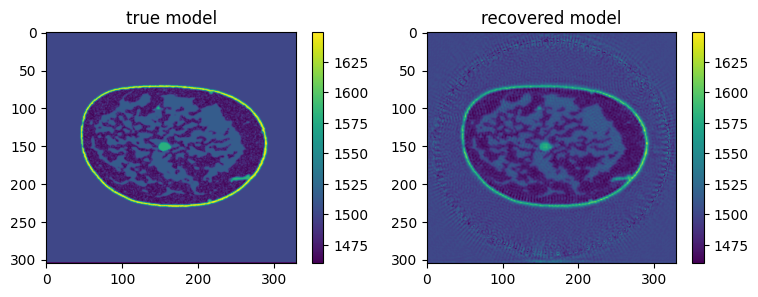

In [12]:
# Compare the true vs the FWI recovered model
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(mi, vmin=mi.min(), vmax=mi.max())
plt.title('true model')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(model.get_model(), vmin=mi.min(), vmax=mi.max())
plt.title('recovered model')
plt.colorbar()
plt.show()

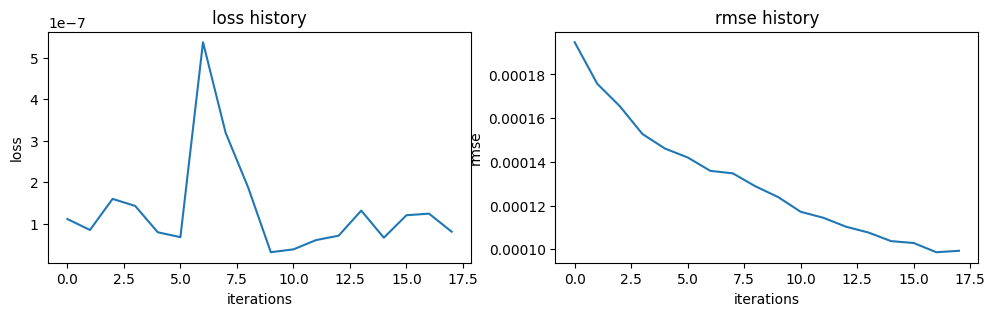

In [13]:
# View the inversion metrics
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(model.loss_history)
plt.title('loss history')
plt.xlabel('iterations')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(model.rmse_history)
plt.title('rmse history')
plt.xlabel('iterations')
plt.ylabel('rmse')
plt.show()